# Transfer Learning wwith TensorFlow part 1: Feature Extraction

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem.

There are two main genefits:

**1.** Can leverage an existing neural network architecture proven to work on problems similar to our own.

**2.** Can levarage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our data.

In [17]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import datetime

from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Downloading and becoming one with the data
- Get data (10% of 10 food classes from Food101)

## Creating data loaders (preparing the data)

We will use `ImageDataGenerator` class to load in our images in batches.

In [8]:
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training image")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size = IMAGE_SHAPE,
                                                          batch_size = BATCH_SIZE,
                                                          class_mode = "categorical")

print("Testing image")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size = IMAGE_SHAPE,
                                             batch_size = BATCH_SIZE,
                                              class_mode = "categorical")

Training image
Found 750 images belonging to 10 classes.
Testing image
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst or model trains)

Callbacks are extra functionality you can add to your model to be performed during or after training. Some of the mosr popular callbacks are:

**1.** Tracking experience with the `TensorBoard` callback

**2.** Model checkpoint with the `ModelCheckPoint` callback

**3.** Stooping a model from training (before it trains too long and overfits) with the `EarlyStopping` cllback


In [12]:
# Create TensorBoard callback and functionized

def create_TensorBoard_callback(dir_name, experiment_name):

    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard lod files to: {log_dir}")
    
    return tensorboard_callback

> This is a TensorFlow callback TensorBoard function. 🤖

In [28]:
# Create function to plot loss curves

def plot_loss_curves(history):

    """
    Returns separate loss curves for training and validation metrics.

    Args:
        history: TemsorFlow history object.
    
    Returns:
        Plots of training/validation loss and accuracy metrics.
    """

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    # Plot the loss
    plt.figure(figsize=(10,7))
    plt.plot(epochs, loss, label="Training loss")
    plt.plot(epochs, val_loss, label="Val loss")
    plt.xlabel("Epochs")
    plt.legend();

    # Plot the accuracy
    plt.figure(figsize=(10,7))
    plt.plot(epochs, accuracy, label="Accuracy")
    plt.plot(epochs, val_accuracy, label="Val accracy")
    plt.xlabel("Epochs")
    plt.legend();



> Create a function to plot loss curves. 🤖

## Creating model using TensorFlow Hub

In the past we used TensorFlow to create our own modles layer by layer from scratch.

Now we are going to do similar procedd, expect the majroity of our model's layers are goind to come from TensorFlow Hub.

We can access pre-traied models on: [TfHub.dev](https://www.kaggle.com/models?tfhub-redirect=true)

In [15]:
# Let's compare the following two models
resnet_url = "https://kaggle.com/models/google/resnet-v2/frameworks/TensorFlow2/variations/50-feature-vector/versions/1"

efficientnet_url = "https://www.kaggle.com/models/tensorflow/efficientnet/frameworks/TensorFlow2/variations/b0-feature-vector/versions/1"

In [18]:
# Let's make a create_model() function to create a model from URL

def create_model(modle_URL, num_classes=10):

    """
    Take a TensorFlow Hub URL and create a Keras Sequential model with it.
    """

    # Download the pretrained model and save it as a Keras layer
    feature_extractor_layer = hub.KerasLayer(modle_URL,
                                             trainable=False, # Freeze the already patterns
                                             name="Feature_Extractions",
                                             input_shape=IMAGE_SHAPE + (3,)) # Equal to (224, 224, 3)
    
    # Create our own model
    model = tf.keras.Sequential([
        feature_extractor_layer,
        tf.keras.layers.Dense(num_classes, activation='softmax', name="output_layer")
    ])

    # Return
    return model

### Create ResNet TensorFlow Hub Feature Extraction Model 👻

In [19]:
# Create resnet model
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

In [20]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Feature_Extractions (KerasL  (None, 2048)             23564800  
 ayer)                                                           
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


> Because we set trainable=`False`. Hence Non-trainable params: 23,564,800.

In [32]:
# Complie a model
resnet_model.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.legacy.Adam(),
    metrics = ["accuracy"]
)

# Fit the model
resnet_history = resnet_model.fit(train_data_10_percent,
                 steps_per_epoch=len(train_data_10_percent),
                 epochs=5,
                 validation_data=test_data,
                 validation_steps=len(test_data),
                 callbacks=[create_TensorBoard_callback("tensorflow_hub",
                                                        experiment_name="resnet50V2")]
                 )

Saving TensorBoard lod files to: tensorflow_hub/resnet50V2/20240205-122500
Epoch 1/5


2024-02-05 12:25:00.536168: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


24/24 [==============================] - ETA: 0s - loss: 0.1986 - accuracy: 0.9587

2024-02-05 12:25:13.569166: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


24/24 [==============================] - 54s 2s/step - loss: 0.1986 - accuracy: 0.9587 - val_loss: 0.6343 - val_accuracy: 0.7944
Epoch 2/5
24/24 [==============================] - 54s 2s/step - loss: 0.1268 - accuracy: 0.9853 - val_loss: 0.6242 - val_accuracy: 0.7972
Epoch 3/5
24/24 [==============================] - 54s 2s/step - loss: 0.0972 - accuracy: 0.9933 - val_loss: 0.6283 - val_accuracy: 0.7900
Epoch 4/5
24/24 [==============================] - 54s 2s/step - loss: 0.0797 - accuracy: 0.9960 - val_loss: 0.6385 - val_accuracy: 0.7940
Epoch 5/5
24/24 [==============================] - 56s 2s/step - loss: 0.0665 - accuracy: 0.9973 - val_loss: 0.6427 - val_accuracy: 0.7952


> WOW!!! THAT IS INCERDICABLE!! 😲

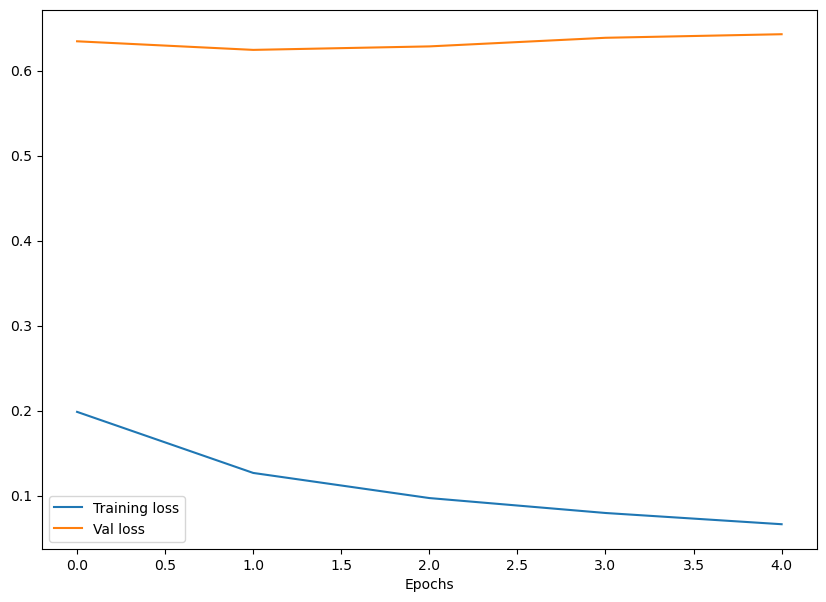

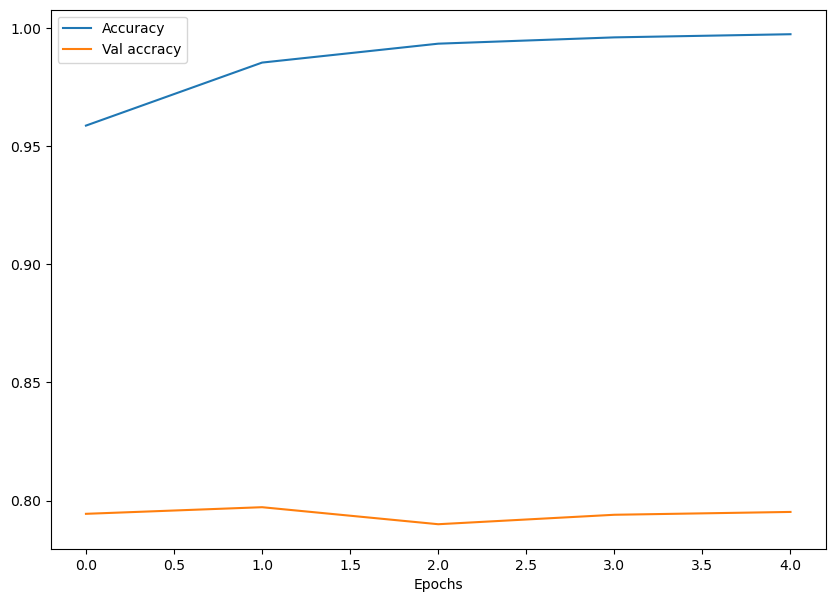

In [33]:
# Plot the history plot
plot_loss_curves(history=resnet_history)

### Create EfficientNet TensorFlow Hub Feature Extraction Model 👻

In [34]:
# Create efficientnet model
efficientnet_model = create_model(efficientnet_url, num_classes=train_data_10_percent.num_classes)

2024-02-05 12:30:12.915805: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype int32 and shape [4]
	 [[{{node inputs}}]]
2024-02-05 12:30:12.915855: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype int32 and shape [4]
	 [[{{node inputs}}]]
2024-02-05 12:30:12.958652: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype int32 and shape [4]
	 [[{{node inputs}}]]
2024-02-05 12:30:12.958701: 

In [35]:
# Complie a model
efficientnet_model.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.legacy.Adam(),
    metrics = ["accuracy"]
)

# Fit the model
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                 steps_per_epoch=len(train_data_10_percent),
                 epochs=5,
                 validation_data=test_data,
                 validation_steps=len(test_data),
                 callbacks=[create_TensorBoard_callback("tensorflow_hub",
                                                        experiment_name="efficientnetb0")]
                 )

Saving TensorBoard lod files to: tensorflow_hub/efficientnetb0/20240205-123014
Epoch 1/5


2024-02-05 12:30:14.991681: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-05 12:30:15.084096: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,?]
	 [[{{node inputs}}]]
2024-02-05 12:30:15.244696: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/top_pool/PartitionedCall_grad/top_pool/PartitionedCall' with dtype floa

24/24 [==============================] - ETA: 0s - loss: 1.8647 - accuracy: 0.4547

2024-02-05 12:30:25.437826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


24/24 [==============================] - 30s 1s/step - loss: 1.8647 - accuracy: 0.4547 - val_loss: 1.3128 - val_accuracy: 0.7348
Epoch 2/5
24/24 [==============================] - 26s 1s/step - loss: 1.0522 - accuracy: 0.7853 - val_loss: 0.8747 - val_accuracy: 0.8204
Epoch 3/5
24/24 [==============================] - 26s 1s/step - loss: 0.7539 - accuracy: 0.8333 - val_loss: 0.7027 - val_accuracy: 0.8432
Epoch 4/5
24/24 [==============================] - 26s 1s/step - loss: 0.6066 - accuracy: 0.8587 - val_loss: 0.6168 - val_accuracy: 0.8568
Epoch 5/5
24/24 [==============================] - 26s 1s/step - loss: 0.5134 - accuracy: 0.8800 - val_loss: 0.5636 - val_accuracy: 0.8596


In [37]:
# Summary the model
efficientnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Feature_Extractions (KerasL  (None, 1280)             4049564   
 ayer)                                                           
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


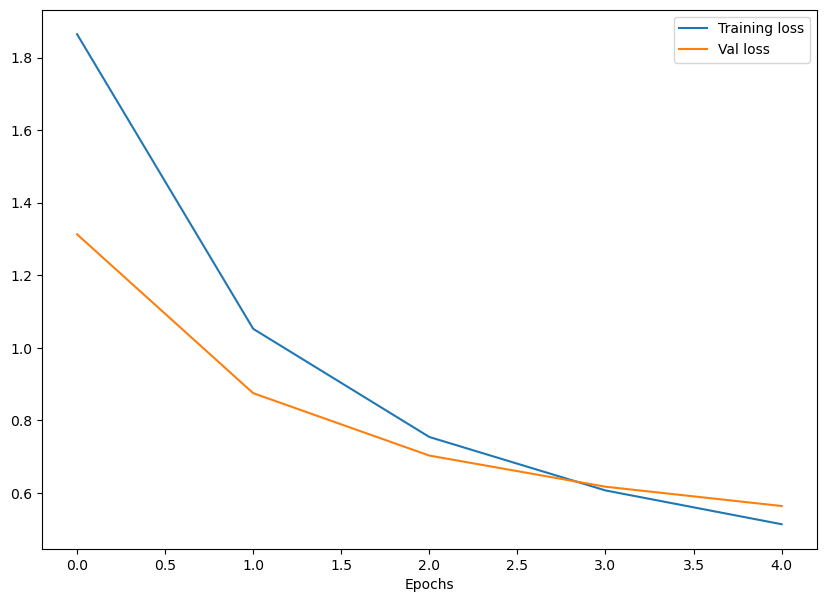

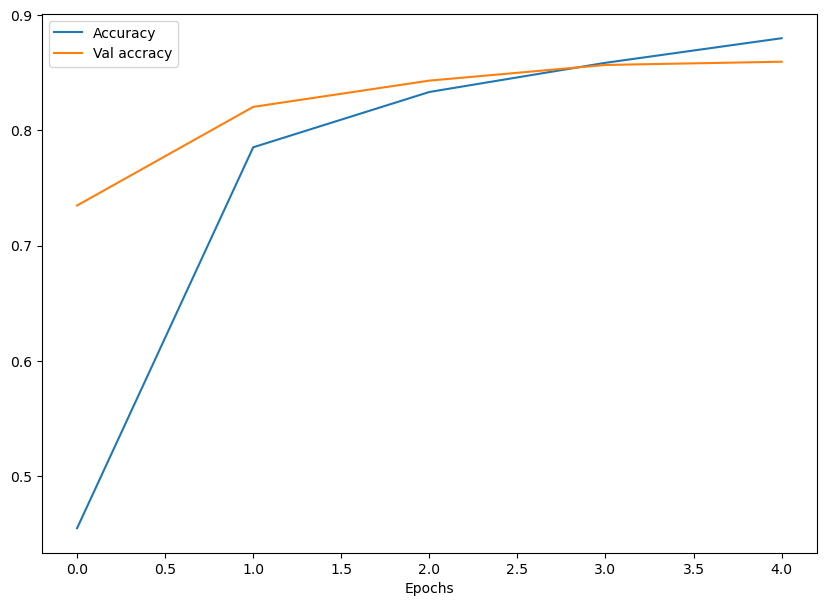

In [36]:
# Plot the loss curves
plot_loss_curves(efficientnet_history)

## Differenct types of transfer learning

* **"As is" transfer learning** - using an existing model with no changes what so ever (e.g using ImageNet model on 1000 ImageNet classes). <br><br>
* **"Feature extraction" transfer learning** - use the prelearned patterns of an existing model and adjust the output layer for your own problem (e.g 1000 classes -> 10 classes) <br><br>
* **"Fine tuning" transfer learning model** - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers) <br><br>

## Comparing our models result usinf TensorBoard

> **Note:** When you upload to TensorBoard.dev, your experiments are published. 👀

In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
    --name "EfficientNet vs. ResNet" \
    --description "Comparing two differenct TF Hub feature extraction model architectures using 10% of the training data" \
    --one_shot